In [1]:
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import numpy as np
import pandas as pd
import PIL

from PIL import Image
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.models import load_model

import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Model
from matplotlib import pyplot
import matplotlib.cm as c_map
from numpy import expand_dims

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

%matplotlib inline

C:\Users\Bombshell\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.chdir(r"E:\MalwareAnal\malimgdataset\archive\dataset_9010\dataset_9010\malimg_dataset\train")
path_root = r"E:\MalwareAnal\malimgdataset\archive\dataset_9010\dataset_9010\malimg_dataset\train"
val_root = r"E:\MalwareAnal\malimgdataset\archive\dataset_9010\dataset_9010\malimg_dataset\validation"

In [3]:
val_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 3000
img_size = (64, 64)
color_mode="grayscale"

val_generator = val_datagen.flow_from_directory(val_root, target_size=img_size, batch_size=batch_size,color_mode=color_mode)

val_steps_per_epoch = val_generator.samples // batch_size

X_val, y_val = next(val_generator)

for i in range(val_steps_per_epoch - 1):
    batch_x, batch_y = next(val_generator)
    X_val = np.concatenate([X_val, batch_x])
    y_val = np.concatenate([y_val, batch_y])
    
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000, color_mode="grayscale")
imgs, labels = next(batches)

Found 935 images belonging to 25 classes.
Found 8404 images belonging to 25 classes.


In [4]:
labelSum = sum(labels)
classKeys = batches.class_indices.keys()
keys = list(classKeys)
classDistDict = {key: value for key, value in zip(keys, labelSum)}

for key, value in classDistDict.items():
    print(f"- {key}: {int(value)}")

- Adialer.C: 97
- Agent.FYI: 91
- Allaple.A: 2824
- Allaple.L: 1491
- Alueron.gen!J: 173
- Autorun.K: 81
- C2LOP.P: 121
- C2LOP.gen!g: 175
- Dialplatform.B: 152
- Dontovo.A: 137
- Fakerean: 306
- Instantaccess: 356
- Lolyda.AA1: 153
- Lolyda.AA2: 159
- Lolyda.AA3: 98
- Lolyda.AT: 134
- Malex.gen!J: 111
- Obfuscator.AD: 117
- Rbot!gen: 133
- Skintrim.N: 55
- Swizzor.gen!E: 103
- Swizzor.gen!I: 107
- VB.AT: 383
- Wintrim.BX: 72
- Yuner.A: 775


In [5]:
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, 
                                                    test_size=0.2, 
                                                    stratify=labels, 
                                                    random_state = 45, 
                                                    shuffle = True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6723, 64, 64, 1), (6723, 25), (1681, 64, 64, 1), (1681, 25))

In [6]:
model = keras.models.load_model(r"E:\MalwareAnal\malimgdataset\MalimgGrayscaleNoClassWeightedFinalTry3.h5")

In [7]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 activation_70 (Activation)  (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 256)       147712    
                                                                 
 activation_71 (Activation)  (None, 29, 29, 256)       0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                

In [8]:
#Visualizing convolutional filters

for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
        # summarize output shape
    print(i, layer.name, layer.output.shape)

0 conv2d_20 (None, 62, 62, 64)
3 conv2d_21 (None, 29, 29, 256)


1/1 [==============================] - 0s 115ms/step


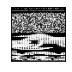

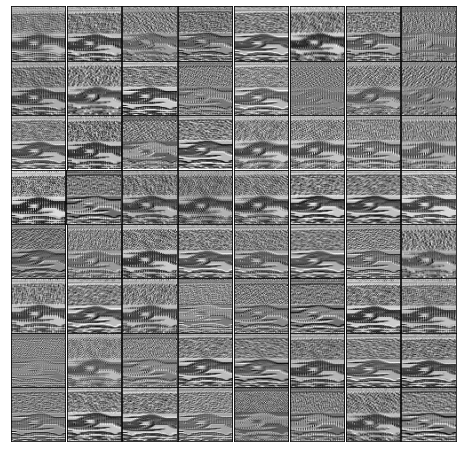

In [10]:
# load the model
# redefine model to output right after the first hidden layer

ixs = [0, 1]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)

# load the image with the required shape
img = load_img(r'E:\MalwareAnal\malimgdatasetbalbenign\train\\' + \
r'Benign\003d2f011b758dff14036fb0fbfc0f60387db551df8048dd83119ebce8ceab8a_img_256.png', 
               target_size=(64, 64), 
               color_mode='grayscale')

# convert the image to an array and expand dimensions so that it represents a single 'sample'
img = img_to_array(img)
img = expand_dims(img, axis=0)

# Prepare the image based on the number of channels
if img.shape[-1] == 1:
    img = img / 255.0  # Normalize the grayscale image
else:
    img = preprocess_input(img)
    
# Get feature maps for the specified layers
feature_maps = model.predict(img)
fmap0 = feature_maps[0]
fmap1 = feature_maps[1]

# Plot the feature maps for each layer
for i, fmap in enumerate([fmap0, fmap1]):
    
    # Get the number of filters in the layer
    n_filters = fmap.shape[-1]
    
    # Calculate the square size for plotting
    square = int(n_filters ** 0.5)
    square += 1 if (n_filters - square ** 2) >= square else 0
    
    # Create a figure with subplots of the correct size
    fig, ax = plt.subplots(nrows=square, ncols=square, figsize=(square, square))
    
    # Flatten the 2D subplot grid using nested loops
    ax_flat = np.array(ax).ravel()

    # Plot all filters in a square grid
    for j in range(n_filters):
        ax_flat[j].set_xticks([])
        ax_flat[j].set_yticks([])
        ax_flat[j].imshow(fmap[0, :, :, j], cmap='gray')

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [11]:
fmap0.shape, fmap1.shape

((1, 64, 64, 1), (1, 62, 62, 64))

In [ ]:
#Visualizing the activations

In [14]:
model = load_model(r"E:\MalwareAnal\malimgdataset\MalimgGrayscaleNoClassWeightedFinalTry3.h5")
img_tensor = load_img(r'E:\MalwareAnal\malimgdatasetbalbenign\train\\' +\
r'Benign\003d2f011b758dff14036fb0fbfc0f60387db551df8048dd83119ebce8ceab8a_img_256.png', 
                      target_size=(64, 64), 
                      color_mode='grayscale')

img_tensor = img_to_array(img_tensor)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

layer_outputs = [layer.output for layer in model.layers[:17]] 
# Extracts the outputs of the top 17 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

1/1 [==============================] - 0s 102ms/step


In [15]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 62, 62, 64)


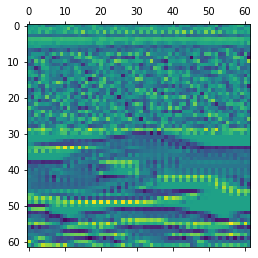

In [16]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')

C:\Users\BOMBSH~1\AppData\Local\Temp/ipykernel_4764/4246069420.py:18: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\BOMBSH~1\AppData\Local\Temp/ipykernel_4764/4246069420.py:21: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


MemoryError: Unable to allocate 919. TiB for an array with shape (157351936, 802816) and data type float64

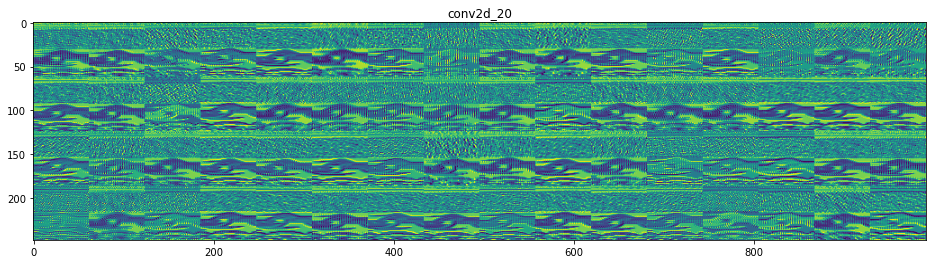

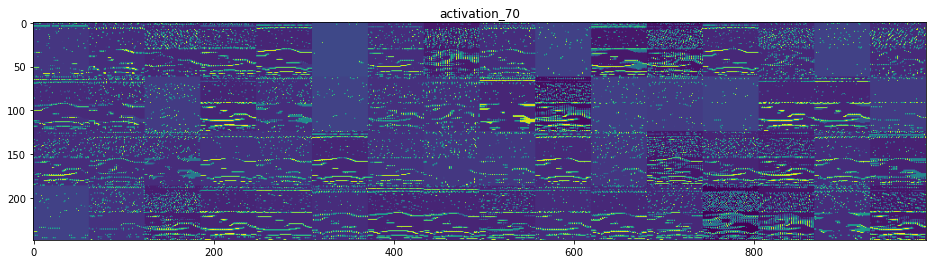

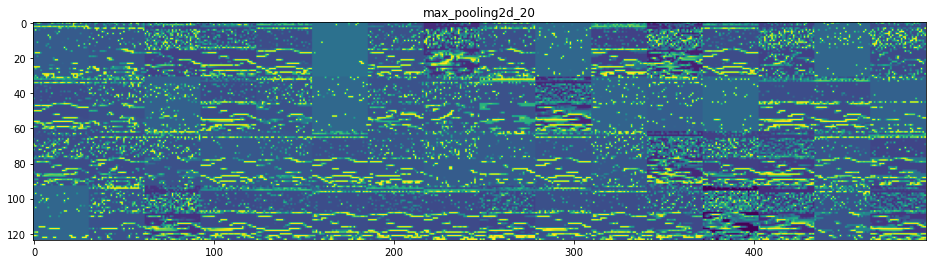

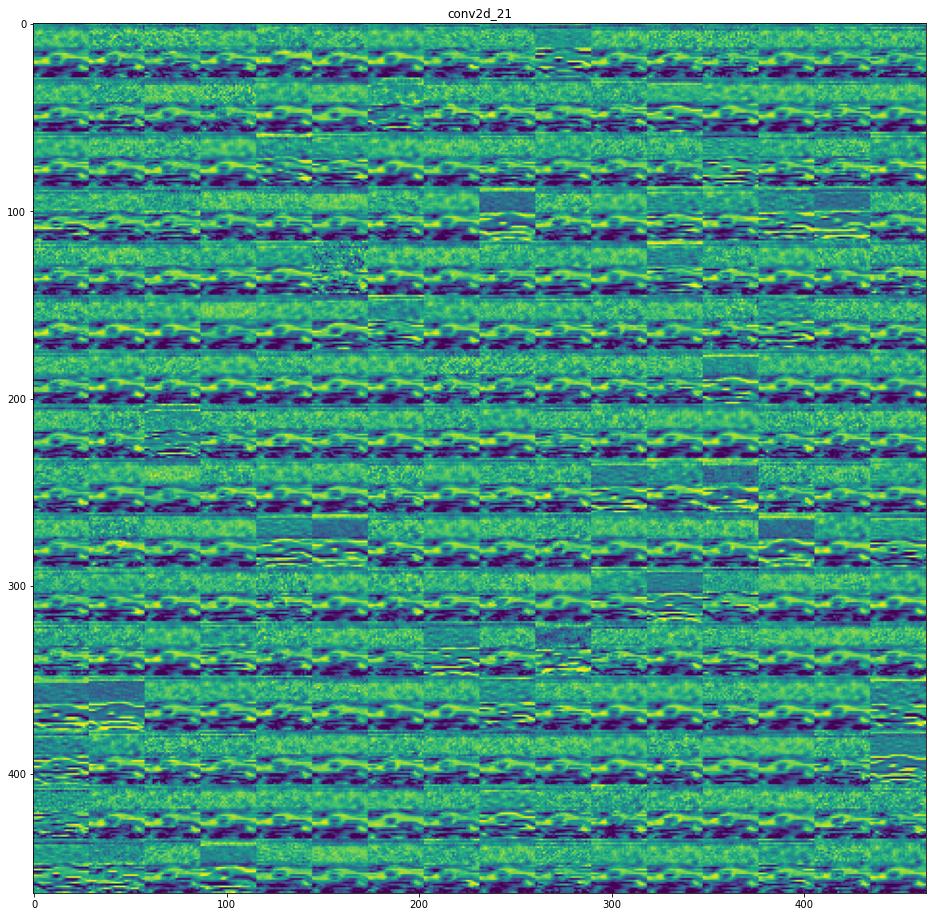

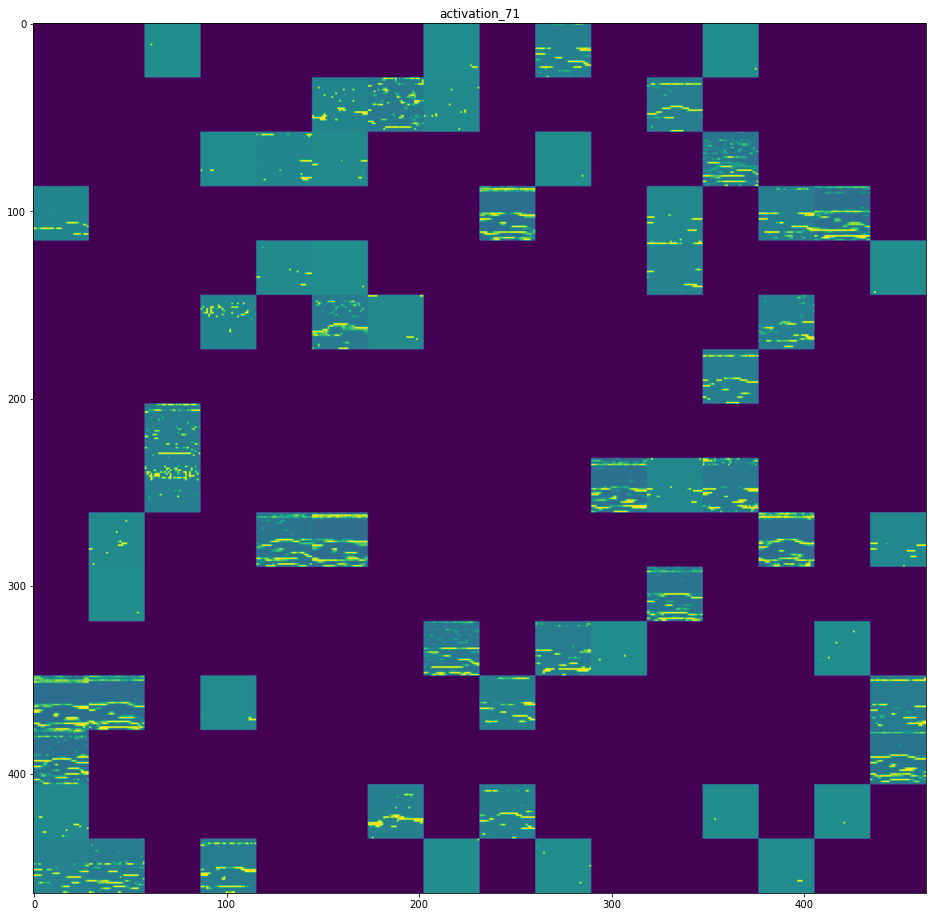

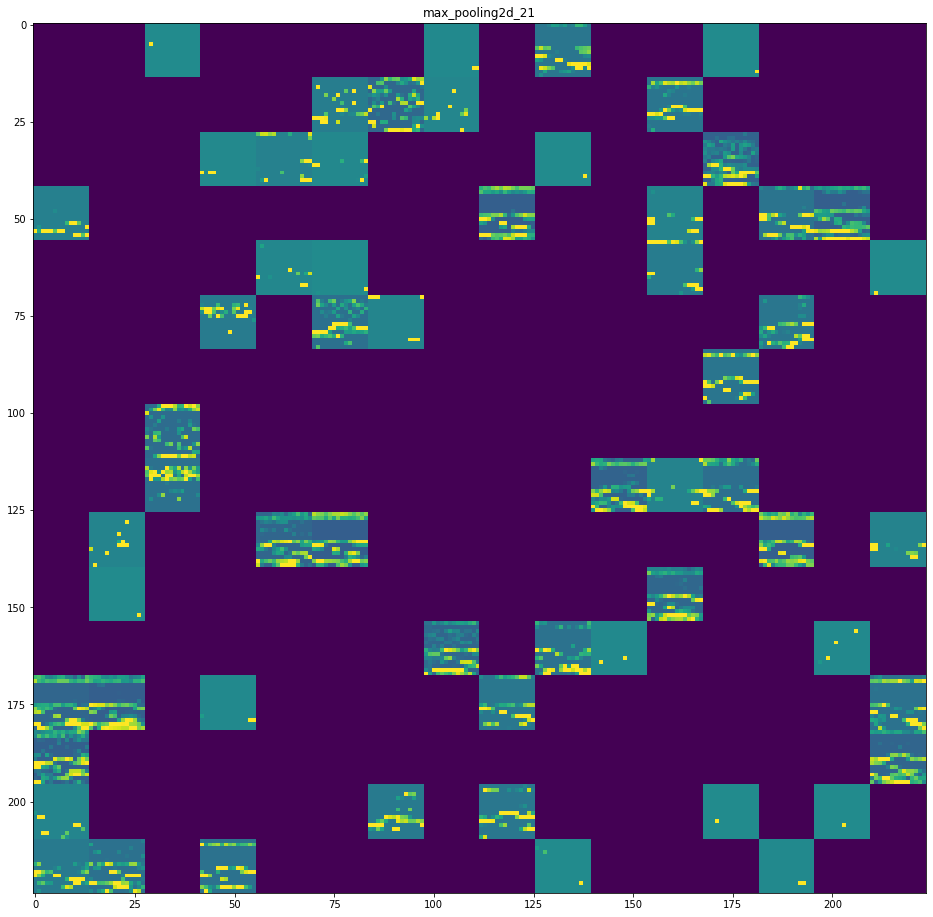

In [17]:
#Visualizing entire feature map (too large to fit in memory)

layer_names = []
for layer in model.layers[:17]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [2]:
#START HERE FOR ORIGINAL-RESOLUTION GRADCAM

#Load Malimg CNN model
model = keras.models.load_model(r"E:\MalwareAnal\malimgdataset\MalimgGrayscaleNoClassWeightedFinalTry3.h5")

for layer in model.layers:
    if isinstance(layer, Conv2D):
        print(f"Conv2D Layer Name: {layer.name}")
        print(f"Filter Size: {layer.kernel_size}")
        print(f"Conv2D Strides: {layer.strides}\n")
        
    elif isinstance(layer, MaxPooling2D):
        print(f"MaxPooling2D Layer Name: {layer.name}")
        print(f"Pool Size: {layer.pool_size}")
        print(f"MaxPooling2D Strides: {layer.strides}")
        
num_layers = len(model2.layers)
print("Total number of layers:", num_layers)

unique_layer_types = set()
for layer in model2.layers:
    unique_layer_types.add(type(layer).__name__)

num_unique_layers = len(unique_layer_types)
print("Total number of unique layer types:", num_unique_layers)

In [6]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 activation_70 (Activation)  (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 256)       147712    
                                                                 
 activation_71 (Activation)  (None, 29, 29, 256)       0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                

In [4]:
layer_name = "conv2d_21"  # Replace with the actual layer name
layer = model.get_layer(layer_name)

# Get the expected input shape of the layer
input_shape = layer.get_input_shape_at(0)  # Assuming you're interested in the first input connection

print("Expected Input Shape:", input_shape)

Expected Input Shape: (None, 31, 31, 64)


In [42]:
# Load your image (Malimg)
img_path = r'C:\MalwareAndBenignDatasets\mmcc_dataset\train\images\Gatak\5XdoJQTAk3Ltu2PONwgC.bytes.png'   
model = keras.models.load_model(r'C:\mmcc_dataset_redo\train\results\MMCCMalwareOnly75MacroAfterKFold.h5')    

IMG_SIZE = (75, 75)

def vectorize_image(img_path, size):
    img = load_img(img_path, target_size=size, color_mode="grayscale")
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array /= 255.0
    return array

vectorized_image = vectorize_image(img_path, size=IMG_SIZE)

# Make a prediction
model_prediction = model.predict(vectorized_image)

1/1 [==============================] - 0s 63ms/step


(34, 34)


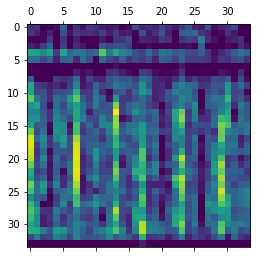

In [44]:
#Displays grad-CAM map of a sample with Matplotlib inline

last_conv_layer = 'conv2d_21'

def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    '''
    Function to visualize grad-cam heatmaps
    '''
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    print(heatmap.numpy().shape)
    return heatmap.numpy()

plt.matshow(get_heatmap(vectorized_image, model, last_conv_layer))
plt.show()

In [45]:
#Displays grad-CAM map ontop of sample at sample's original resolution

def superimpose_gradcam(img_path, heatmap, output_path="grad_cam_image.jpg", alpha=0.5):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = cm.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(output_path) # Saving the superimposed image
    Image.open(output_path).show() # Displaying Grad-CAM Superimposed Image
    
superimpose_gradcam(img_path, get_heatmap(vectorized_image, model, last_conv_layer))

(34, 34)


In [20]:
#Displays grad-CAM maps on sample at CNN-resolution (64x64 or 75x75)

def superimpose_gradcam_on_resized(img_path, heatmap, output_path="grad_cam_image.jpg", alpha=0.5):
    img = load_img(img_path, target_size=(64, 64))
    img = img_to_array(img)
    
    # Normalize the heatmap
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Apply a colormap
    jet = c_map.get_cmap("jet_r")
    jet_heatmap = jet(heatmap)[:, :, :3] * 255  # Scale to 0-255 RGB values

    # Resize the heatmap to match the dimensions of the 64x64 image
    resized_heatmap = cv2.resize(jet_heatmap, (64, 64)).astype(np.uint8)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img.astype(np.uint8), 1 - alpha, resized_heatmap, alpha, 0)

    # Save and display the superimposed image
    cv2.imwrite(output_path, superimposed_img)
    Image.open(output_path).show()  # Displaying Grad-CAM Superimposed Image

# Example usage:
superimpose_gradcam_on_resized(img_path, get_heatmap(vectorized_image, model, last_conv_layer))


(29, 29)


C:\Users\BOMBSH~1\AppData\Local\Temp/ipykernel_286324/3259702198.py:10: RuntimeWarning: divide by zero encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
C:\Users\BOMBSH~1\AppData\Local\Temp/ipykernel_286324/3259702198.py:10: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))


In [61]:
#Generates sample-resolution grad-CAM maps for every image in a class (directory)

#To use: Replace the string in load_model's quotes with the model's path

#Example: model = tf.keras.models.load_model(r"C:\path\to\your_model.h5")

# Define the target size for the images 
#(64,64) for CNN64's, (75,75) for CNN75's and IV3
IMG_SIZE = (75, 75)

#Find the name of the last convolutional layer with model.summary()
#and replace the field next to last_conv_layer with it. 
last_conv_layer = 'conv2d_21'

#Provide input directory of .png images to extract CAMs from, 
#and an output directory to save them to.
input_dir = r'C:\Users\Bombshell\Pictures\Thesis figures\resizevizdatasettests\swizzorgeni75'
output_dir = r'C:\Users\Bombshell\Pictures\Thesis figures\gradcam\swizzorgeni75gradcam'

def vectorize_image(img_path, size):
    img = load_img(img_path, target_size=size, color_mode="grayscale")
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array /= 255.0
    return array

def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_gradcam_on_original(img_path, heatmap, output_path, alpha=0.5):
    original_img = cv2.imread(img_path)
    heatmap = np.array(heatmap)
    
    # Resize the heatmap to match the size of the original image
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_normalized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized))

    # Apply a colormap
    jet = cm.get_cmap("jet_r")
    colored_heatmap = jet(heatmap_normalized)[:, :, :3] * 255

    # Overlay the colored heatmap on the original image
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, colored_heatmap.astype(np.uint8), alpha, 0)

    # Save the superimposed image at full resolution
    cv2.imwrite(output_path, superimposed_img)

def process_images_in_directory(input_dir, output_dir):
    for filename in tqdm(os.listdir(input_dir)):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(input_dir, filename)
            vectorized_image = vectorize_image(image_path, size=IMG_SIZE)
            heatmap = get_heatmap(vectorized_image, model, last_conv_layer)
            output_path = os.path.join(output_dir, f"heatmap_{filename}")
            superimpose_gradcam_on_original(image_path, heatmap, output_path)
            #print(f"Heatmap saved for {filename}.")

# Process all images in the input directory
process_images_in_directory(input_dir, output_dir)

 19%|███████████████▏                                                                 | 20/107 [00:01<00:06, 14.18it/s]C:\Users\BOMBSH~1\AppData\Local\Temp/ipykernel_43280/76457518.py:59: RuntimeWarning: divide by zero encountered in divide
  heatmap_normalized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized))
C:\Users\BOMBSH~1\AppData\Local\Temp/ipykernel_43280/76457518.py:59: RuntimeWarning: invalid value encountered in divide
  heatmap_normalized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized))
100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:07<00:00, 14.79it/s]


In [41]:
#Overlays grad-CAM heatmaps stored in heatmap_dir and aggregates 
#them into an image stored in output_dir

heatmap_dir = r'C:\Users\Bombshell\Pictures\Thesis figures\gradcam\gatak gradcam64'
output_dir = r'C:\Users\Bombshell\Pictures\Thesis figures\gradcam\gatak gradcam64 agg'
os.makedirs(output_dir, exist_ok=True)

heatmaps = []

# Load each individual heatmap
for filename in os.listdir(heatmap_dir):
    if filename.endswith(".png"):
        heatmap_path = os.path.join(heatmap_dir, filename)
        heatmap = Image.open(heatmap_path)
        heatmaps.append(heatmap)

# Check if heatmaps were loaded successfully
if len(heatmaps) == 0:
    print("No valid heatmaps found in the directory.")
else:
    # Get the dimensions of the first heatmap
    width, height = heatmaps[0].size

    # Initialize an array to hold the maximum pixel values across all heatmaps
    max_pixel_values = np.zeros((width, height, 3), dtype=np.uint8)

    # Process each heatmap to find the maximum pixel values
    for heatmap in heatmaps:
        heatmap_array = np.array(heatmap)
        max_pixel_values = np.maximum(max_pixel_values, heatmap_array)

    # Create an image from the maximum pixel values
    global_heatmap_rgb = Image.fromarray(max_pixel_values)

    # Save the global heatmap as an RGB image
    global_heatmap_output_path = os.path.join(output_dir, 'global_heatmap.png')
    global_heatmap_rgb.save(global_heatmap_output_path)

    print("Global heatmap saved successfully.")

Global heatmap saved successfully.


In [81]:
#Checks if images in image_dir are grayscale using HSV

image_dir = r"C:\Users\Bombshell\Pictures\Thesis figures\gradcam\malexsamplesizespywaregengradcam"
grayscale_count = 0
saturation_threshold = 20

for filename in os.listdir(image_dir):
    if filename.endswith((".png")):
        
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)

        # Convert the image to HSV color space
        hsv_image = image.convert("HSV")

        # Check for grayscale by examining saturation (S) values
        saturation_values = list(hsv_image.getdata(band=1))  # Band 1 is for S (Saturation)

        # Check if all saturation values are below the threshold
        if all(saturation < saturation_threshold for saturation in saturation_values):
            grayscale_count += 1

# Print the total number of grayscale images
print(f"Total grayscale images: {grayscale_count}")

Total grayscale images: 235


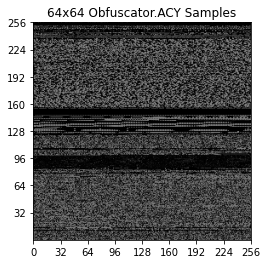

In [19]:
img_path = r'C:\Users\Bombshell\Pictures\Thesis figures\gradcam\malexsamplesizespywaregengradcam\heatmap_9d8549b9aca581f41637215c9a30f274275e4423e4bcfe909b1d244ff65b1b32_img_256.png'

# Load the image using PIL
img = Image.open(img_path)

fig, ax = plt.subplots()

# Plot the image with specified extent
ax.imshow(img, extent=[0, img.width, img.height, 0])

# Set the y-axis tick positions and labels
yticks = range(0, img.height, 32)
yticklabels = range(img.height, 0, -32)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

plt.title('64x64 Obfuscator.ACY Samples')

# Move the left spine of the plot to the y-axis zero position
ax.spines['left'].set_position('zero')

# Set the x-axis tick positions and labels
xticks = range(0, img.width + 1, 32)
xticklabels = range(0, img.width + 1, 32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# Show the plot
plt.show()